In [1]:
import os
import io
import re
import numpy as np
import pandas as pd
import platform
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt

import cv2
from google.cloud import vision

In [2]:
# OCR API 불러오기
# \ => /로 변환해야 파일 인식 가능(안바꾸면 유니코드 에러 발생함)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users\Hong Ji Young\Desktop/Health-C/health-c-377913-17227fcd7bd5.json'
 
client_options = {'api_endpoint': 'eu-vision.googleapis.com'}
client = vision.ImageAnnotatorClient(client_options=client_options)

In [3]:
# 이미지 불러오기
path = 'img2.jpg'
with io.open(path, 'rb') as img_file:
    content = img_file.read()

In [4]:
# 이미지 OCR, 글자 인식(30초 정도 걸림)
image = vision.Image(content=content)
 
response = client.text_detection(image=image)
texts = response.text_annotations

In [118]:
# 읽어온 글자 중 재료명만 골라내기 위한 작업<1>
#     특수문자 제거, 순수한글 & 숫사 & 영어만 가져와서 리스트로 생성
lst = []
special_char = ''
for text in texts[0].description.split(','):
    x = [re.sub('[^A-Za-z0-9가-힣]', '', t) for t in text.split()]
    for j in x:
        lst.append(re.sub('[^A-Za-z0-9가-힣]', '', j))

## 엑셀 파일 읽어오기

In [101]:
# xlsx파일 dataframe으로 생성
materials = pd.read_excel('materials_all.xlsx')

In [102]:
materials.head()

,Unnamed: 0,원재료,대표원재료명,원재료이명
0,0,Abiu열매,Abiu열매,NaN
1,1,Agathi꽃,Agathi꽃,NaN
2,2,Agathi잎,Agathi잎,NaN
3,3,Alder Buckthorn,Alder Buckthorn,NaN
4,4,Algarrobo Blanco,Algarrobo Blanco,NaN


In [119]:
food_materials = pd.DataFrame({'원재료' : list(set(lst))})
result = pd.merge(materials, food_materials
                   , how="inner", right_on="원재료", left_on="대표원재료명")

In [120]:
list(result["대표원재료명"])

['대두',
 '땅콩',
 '밀',
 '밀가루',
 '코코아매스',
 '맥아엑기스',
 '돼지고기',
 '우유',
 '유당',
 '알긴산프로필렌글리콜',
 '효모',
 '단백질',
 '폴리프로필렌',
 '설탕',
 '쇼트닝',
 '초콜릿',
 '가공버터',
 '가공유',
 '전지분골드',
 '준초콜릿',
 '효소제',
 '나트륨']

In [89]:
# 사용하지 않는 코드(참고만)
common_materials = pd.DataFrame()
for txt in lst:
    print(materials[materials['원재료'].str.contains(txt)])
#     print(materials.query('원재료.str.contains(@txt)'), engine="python")

       Unnamed: 0                                               원재료
14697       14697       폴리알킬렌(에틸렌-프로필렌 포함)글리콜부톡시모노에테르(평균분자량 3,300) 
14705       14705                  옥시란과 메틸옥시란의 블록공중합체(평균분자량 1,900) 
14706       14706                옥시란과 메틸옥시란의 블록공중합체(최소평균분자량 2,000) 
14707       14707  옥시란과 메틸옥시란의 블록공중합체 (메틸옥시란이 27～31몰, 평균분자량 2,000) 
14734       14734      폴리알킬렌(에틸렌-프로필렌 포함)글리콜부톡시모노에테르 (최소분자량 2,400) 
...           ...                                               ...
27260       27260                                       COLOUR 100 
27967       27967               POLYETHYLENE GLYCOL (400) DIOLEATE 
27968       27968               POLYETHYLENE GLYCOL (600) DIOLEATE 
27973       27973                   POLYOXYETHYLENE (600) DIOLEATE 
27976       27976            POLYOXYETHYLENE (600) MONORICINOLEATE 

[296 rows x 2 columns]


# OpenCV와 줄바꿈 해결

### 줄바꿈 '\n' 문자열을 ''으로 바꿔서 붙여서 해결

In [16]:
texts[0].description.replace("\n", "")

'00OPEN빼빼로 판매수익금롯데제과 Sweet Home지역아동센터건립기금으로 사용됩니다.유통기한 밑면표기일까지(연.월.일)식품유형 초콜릿가공품|내포장재질 폴리프로필렌품목보고번호 F2(양산) 19780614009498,F4(대전)19960242067376영업장의 명칭 롯데제과㈜ 서울시 영등포구 양평로21길 25및 소재지원재료명 준초콜릿 | (설탕, 가공유지(싱가포르산),혼합분유(외국산·(싱가포르·프랑스·네덜란드 등);전지분유,코코아매스),코코아매스,유당), 밀가루(밀:미국산,캐나다산),준초콜릿II(설탕,혼합분유(외국산(싱가포르 • 프랑스·네덜란드 등);전지분유,코코아매스),가공유지(싱가포르산),코코아매스,유당),시드(곡류가공품),설탕,쇼트닝,가공연유,가공버터,전분가공품,맥아엑기스,전지분골드 1,정제소금,산료), 효소제,효모도조절제3종, 기타과당,혼합제제(합성향료,밀가루,비타민C, 카제인나트륨,알긴산프로필렌글리콜),혼합제제II(바닐라추출물,합성향밀,대두,우유,땅콩 함유•직사광선 및 습기를 피해 서늘한 곳에 진열, 유통 중 변질품은 구입상점 및 본사에서 항상 교환 • 소비자기본법에 의한 피해 보상• 휴지줍는 고운마음, 안버리는 밝은마음• 부정, 불량식품 신고는 국번없이 1399•달걀,쇠고기,돼지고기 혼입 가능•●• 고객지원센터080-024-6060수신자요금부담http://www.lottecont.co.kr중 초콜릿 표면이 녹아 하얀 반점이 생길 수 있으나, 인체에무해하니 드셔도 괜찮습니다.영양정보지방 11g 20%나트륨 140 mg7% | 탄수화물 24g7% | 당류 13g 13%트랜스지방 0g포화지방 6g 40%콜레스테롤 5mg미만 1 %*1일 영양성분 기준치에 대한 비율(%)은 2,000kcal 기준이므로 개인의 필요 열량에 따라 다를 수 있습니다.1 롯데제과단백질 3g5%눌러서분리배출 해주세요총 내용량 39 g205 kcalSweet Eco롯데제과와 함께 환경을 지켜요△ 편리한 분리배출'

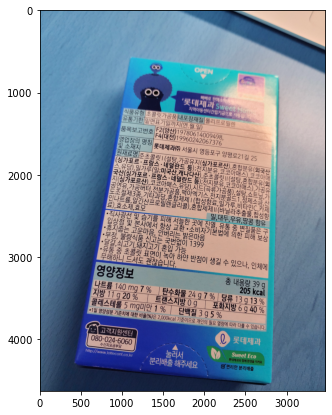

In [38]:
cvt_img = cv2.imread(path, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=[20, 7])
plt.subplot(1, 2, 1)
plt.imshow(cvt_img)

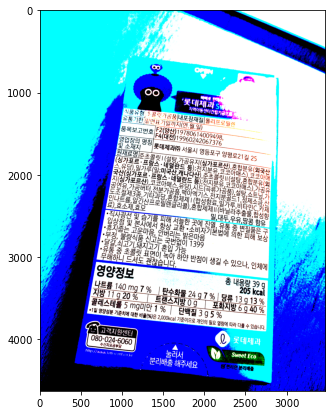

In [39]:
cvt_img = cv2.threshold(cvt_img, 120, 255, cv2.THRESH_BINARY)[1]

plt.figure(figsize=[20, 7])
plt.subplot(1, 2, 1)
plt.imshow(cvt_img)

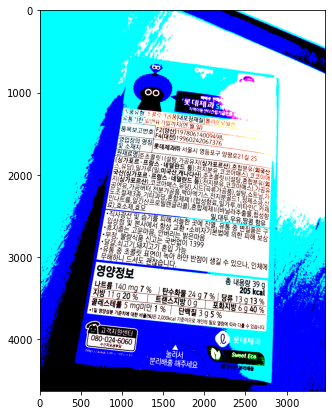

In [41]:
cvt_img = cv2.medianBlur(cvt_img, ksize=5)

plt.figure(figsize=[20, 7])
plt.subplot(1, 2, 1)
plt.imshow(cvt_img)

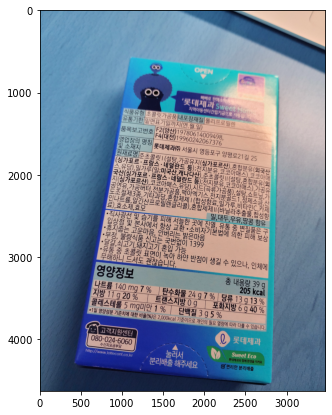

In [42]:
cvt_img = cv2.imread(path, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=[20, 7])
plt.subplot(1, 2, 1)
plt.imshow(cvt_img)

In [44]:
# with io.open(cvt_img, 'rb') as img_file:
    # content = img_file.read()
# 이미지 OCR, 글자 인식(30초 정도 걸림)
image = vision.Image(content=cvt_img)
 
response = client.text_detection(image=image)
texts = response.text_annotations

TypeError: expected bytes, numpy.ndarray found